## A binary classification model to predict whether a Spotify track will be explicit (True/False) based on its features

In [1]:
# Data preparation

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# load data 
df = pd.read_csv('spotify_tracks.csv')

# select the features and target
features = ['genre', 'duration_ms', 'popularity', 'artists'].copy()
target = 'explicit'

# prepare data
df = df[features + [target]].dropna()
df['explicit'] = df['explicit'].astype('int64')

# check class balance
print(df['explicit'].value_counts(normalize=True))

explicit
0    0.810476
1    0.189524
Name: proportion, dtype: float64


In [2]:
## Feature Engineering

# create new features
df['artist_frequency'] = df.groupby('artists')['artists'].transform('count')

#drop the original columns
df['duration_min'] = df['duration_ms'] / 60000
df = df.drop(['duration_ms', 'artists'], axis=1)

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# check correlation with target
print(numeric_df.corr()[['explicit']].sort_values('explicit', ascending=False))


                  explicit
explicit          1.000000
popularity        0.070612
artist_frequency  0.006128
duration_min     -0.047099


In [3]:
# Train/Test Split

X = df.drop('explicit', axis=1)
y = df['explicit']

#split to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [4]:
# Build the Pipeline

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# define preprocessing 
numeric_features = ['duration_min', 'popularity', 'artist_frequency']
categorical_features = ['genre']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

#build pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])





              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1021
           1       0.57      0.26      0.36       239

    accuracy                           0.82      1260
   macro avg       0.71      0.61      0.63      1260
weighted avg       0.79      0.82      0.79      1260

ROC_AUC: 0.73


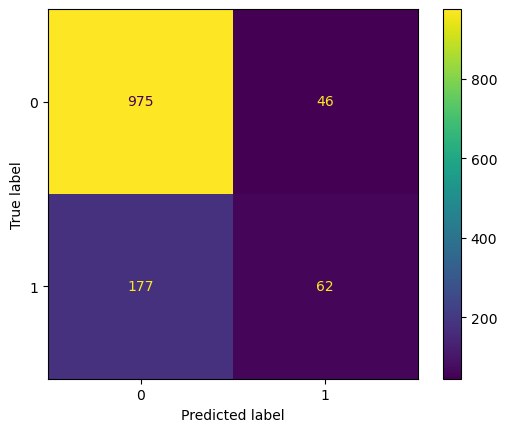

In [5]:
# Train and Evaluate

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

# train
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)
# probabilities for AUC
y_proba = model.predict_proba(X_test)[:, 1]

# evaluate
print(classification_report(y_test, y_pred))
print(f'ROC_AUC: {roc_auc_score(y_test, y_proba):.2f}')

# plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


In [6]:
# Save the trained model
import joblib
joblib.dump(model, 'explicit_predictor.joblib')

['explicit_predictor.joblib']

In [7]:
# Improve model

# Option 2: Use SMOTE oversampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

model = make_pipeline(
    preprocessor,
    SMOTE(random_state=42),
    RandomForestClassifier(random_state=42)
)

In [8]:
# different models

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Example with XGBoost
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(scale_pos_weight=sum(y==0)/sum(y==1)))
])